In [1]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import sys
import h5py

In [2]:
#ninapro 데이터셋 불러오기
ninapro_df = pd.DataFrame()
for i in range (1,11):
    adress = f"ninapro_db5/s{i}/S{i}_E2_A1"
    filename = adress
    mat = sio.loadmat(filename)
    emg = mat['emg']
    Restimulus = mat['restimulus']
    rerepetition = mat['rerepetition']
    df_emg = pd.DataFrame(emg)
    df_Restimulus = pd.DataFrame(Restimulus)
#    df_rerepetition = pd.DataFrame(rerepetition)
    df = pd.concat([df_emg, df_Restimulus], axis=1)
#    df = pd.concat([df, df_rerepetition], axis=1)
#    df.columns = ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus', 'rerepetition']
    df.columns = ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus']
    ninapro_df = pd.concat([ninapro_df, df])

In [3]:
#upsampling
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.preprocessing import StandardScaler

def preprocess_emg_data(df):
   
    # 설정 값
    ORIGINAL_FS = 200   # 기존 주파수
    TARGET_FS = 1000    # 목표 주파수
    RESAMPLE_RATIO = TARGET_FS / ORIGINAL_FS # 5.0

    # 1. 데이터와 라벨 분리
    # 마지막 컬럼이 Restimulus라고 가정
    feature_cols = df.columns[:-1]  # EMG 채널 16개
    label_col = df.columns[-1]      # Restimulus
    
    print(f"설정 확인: {ORIGINAL_FS}Hz -> {TARGET_FS}Hz 변환 (비율: {RESAMPLE_RATIO}배)")
    
    # 2. 동작(Class)별 구간 자르기
    # 단순히 라벨값(0,1,2..)으로 묶는게 아니라, 시간 순서상 '연속된 동작' 단위로 잘라야 함
    # 라벨이 변하는 지점마다 새로운 그룹 ID 부여
    df['segment_id'] = (df[label_col] != df[label_col].shift()).cumsum()
    
    processed_data_list = []
    labels_list = []
    
    # 그룹별 처리
    print("데이터 변환 진행 중 (Splitting -> Upsampling -> Normalization)...")
    
    for _, group in df.groupby('segment_id'):
        # 현재 구간의 라벨
        current_label = group[label_col].iloc[0]
        
        # (선택사항) 0번 클래스(Rest/휴식)가 학습에 불필요하다면 아래 주석 해제하여 건너뛰기
        if current_label == 0: continue
        
        # 해당 구간의 EMG 데이터 추출 (Numpy 변환)
        raw_signal = group[feature_cols].values
        
        # 3. 1000Hz Upsampling
        # 변환 후 샘플 수 계산: 현재 길이 * 5
        new_length = int(len(raw_signal) * RESAMPLE_RATIO)
        
        if new_length > 0:
            # Fourier method를 이용한 리샘플링 (신호 손실 최소화)
            upsampled_signal = signal.resample(raw_signal, new_length)
            
            # 4. Z-score 정규화 (Standardization)
            # 각 동작 구간(Segment)마다 독립적으로 정규화 수행
            scaler = StandardScaler()
            normalized_signal = scaler.fit_transform(upsampled_signal)
            
            processed_data_list.append(normalized_signal)
            labels_list.append(current_label)
            
    # 5. 모델 입력을 위한 Padding 및 Numpy Stacking
    # 모델에 넣으려면 모든 데이터의 Time Step(길이)이 같아야 함.
    # 가장 긴 데이터를 기준으로 나머지는 0으로 채움 (Zero-padding)
    
    max_seq_len = max(len(d) for d in processed_data_list)
    num_samples = len(processed_data_list)
    num_channels = len(feature_cols) # 16
    
    # 결과 담을 빈 배열 생성 (Batch, Time, Channel)
    X_padded = np.zeros((num_samples, max_seq_len, num_channels))
    
    # 데이터 채워넣기
    for i, data in enumerate(processed_data_list):
        length = len(data)
        X_padded[i, :length, :] = data  # 앞쪽부터 데이터 채움 (Post-padding 0)
        
    y_labels = np.array(labels_list)
    
    print("-" * 30)
    print("변환 완료!")
    print(f"총 샘플(동작) 개수: {num_samples}")
    print(f"최대 시퀀스 길이 (Max Time Steps): {max_seq_len}")
    print(f"입력 데이터 Shape (X): {X_padded.shape}") # (Batch, Time, 16)
    print(f"라벨 데이터 Shape (y): {y_labels.shape}")
    print("-" * 30)
    
    return X_padded, y_labels


X_up, y_up = preprocess_emg_data(ninapro_df)

# 3. 모델 입력 확인
# 1D CNN + Attention 모델에 입력으로 'X'를, 타겟으로 'y'를 사용하면 됩니다.

설정 확인: 200Hz -> 1000Hz 변환 (비율: 5.0배)
데이터 변환 진행 중 (Splitting -> Upsampling -> Normalization)...
------------------------------
변환 완료!
총 샘플(동작) 개수: 1020
최대 시퀀스 길이 (Max Time Steps): 7245
입력 데이터 Shape (X): (1020, 7245, 16)
라벨 데이터 Shape (y): (1020,)
------------------------------


In [9]:
#nature 데이터셋 불러오기
grasp_mapping = {
    1: 6,
    2: 18,
    3: 7,
    4: 5,
    5: 19,
    6: 0
}

nature_df = pd.DataFrame()
for i in range(1, 9):
    for j in range(1,3):
        for k in range(1,3):
            filename = fr'nature_data\data\participant_{i}\participant{i}_day{j}_block{k}\emg_data.hdf5'
            data_parame = pd.read_csv(fr'nature_data\data\participant_{i}\participant{i}_day{j}_block{k}\trials.csv') 
            nature_data = h5py.File(filename, 'r')
            data_parame['grasp'] = data_parame['grasp'].replace(grasp_mapping)
            for l in range(0, 150):
                df = pd.DataFrame(np.array(nature_data[f"{l}"]))
                df=df.transpose()
                df['Restimulus'] = ''
                df['Restimulus'] = data_parame['grasp'].iloc[l]
                nature_df = pd.concat([nature_df, df], axis=0)
                print(f"nature_df{i}{j}{k}{l} 종료")
nature_df.columns = ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus']
#nature_df.to_csv('nature_df.csv', index=False)

nature_df1110 종료
nature_df1111 종료
nature_df1112 종료
nature_df1113 종료
nature_df1114 종료
nature_df1115 종료
nature_df1116 종료
nature_df1117 종료
nature_df1118 종료
nature_df1119 종료
nature_df11110 종료
nature_df11111 종료
nature_df11112 종료
nature_df11113 종료
nature_df11114 종료
nature_df11115 종료
nature_df11116 종료
nature_df11117 종료
nature_df11118 종료
nature_df11119 종료
nature_df11120 종료
nature_df11121 종료
nature_df11122 종료
nature_df11123 종료
nature_df11124 종료
nature_df11125 종료
nature_df11126 종료
nature_df11127 종료
nature_df11128 종료
nature_df11129 종료
nature_df11130 종료
nature_df11131 종료
nature_df11132 종료
nature_df11133 종료
nature_df11134 종료
nature_df11135 종료
nature_df11136 종료
nature_df11137 종료
nature_df11138 종료
nature_df11139 종료
nature_df11140 종료
nature_df11141 종료
nature_df11142 종료
nature_df11143 종료
nature_df11144 종료
nature_df11145 종료
nature_df11146 종료
nature_df11147 종료
nature_df11148 종료
nature_df11149 종료
nature_df11150 종료
nature_df11151 종료
nature_df11152 종료
nature_df11153 종료
nature_df11154 종료
nature_df11155 종료
na

KeyboardInterrupt: 

In [4]:
#nature df csv불러오는 코드
nature_df = pd.read_csv('nature_df.csv')
nature_df

,emg1,emg2,emg3,emg4,emg5,emg6,emg7,emg8,emg9,emg10,emg11,emg12,emg13,emg14,emg15,emg16,Restimulus
0,0.000038,0.000025,0.000008,0.000008,-0.000016,-0.000002,-0.000005,-0.000010,0.000017,0.000061,-0.000008,-0.000008,-0.000022,-0.000008,-0.000016,-0.000013,7
1,0.000020,0.000026,0.000010,0.000008,-0.000017,-0.000002,-0.000008,-0.000007,0.000014,0.000043,-0.000011,-0.000009,-0.000022,-0.000012,-0.000016,-0.000018,7
2,0.000009,0.000026,0.000011,0.000008,-0.000024,-0.000004,-0.000013,-0.000005,0.000014,0.000025,-0.000015,-0.000011,-0.000018,-0.000013,-0.000013,-0.000016,7
3,0.000012,0.000023,0.000009,0.000007,-0.000041,-0.000009,-0.000016,-0.000006,0.000012,0.000010,-0.000017,-0.000012,-0.000014,-0.000013,-0.000008,-0.000013,7
4,0.000021,0.000020,0.000006,0.000005,-0.000044,-0.000015,-0.000018,-0.000008,0.000007,0.000003,-0.000016,-0.000011,-0.000012,-0.000014,-0.000006,-0.000012,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47973915,0.000030,0.000042,0.000010,0.000012,-0.000030,-0.000011,-0.000027,-0.000002,-0.000092,-0.000030,-0.000013,-0.000016,-0.000010,-0.000008,-0.000013,-0.000011,18
47973916,0.000030,0.000060,0.000011,0.000013,-0.000030,-0.000009,-0.000026,-0.000013,-0.000086,-0.000012,-0.000010,-0.000015,-0.000009,-0.000008,-0.000014,-0.000011,18
47973917,0.000024,0.000074,0.000012,0.000014,-0.000029,-0.000006,-0.000025,-0.000014,-0.000072,0.000002,-0.000010,-0.000016,-0.000011,-0.000008,-0.000014,-0.000013,18
47973918,0.000015,0.000077,0.000013,0.000016,-0.000027,-0.000005,-0.000021,-0.000014,-0.000051,0.000002,-0.000012,-0.000017,-0.000013,-0.000006,-0.000013,-0.000014,18


In [5]:
#down sampling code
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # 진행 상황 표시용 (설치 필요: pip install tqdm)

def process_large_emg_data(df):
    """
    4800만 행 규모의 2000Hz EMG 데이터를 처리하여 1D CNN 모델 입력용 Numpy 배열로 변환
    
    Args:
        df (pd.DataFrame): 2000Hz Raw 데이터 (Rows x 17 cols)
                           (1~16 col: EMG 센서, 17 col: Restimulus 클래스)
    
    Returns:
        X_padded (np.array): (Batch_Size, Max_Time_Steps, 16)
        y_labels (np.array): (Batch_Size,)
    """
    
    # ---------------------------------------------------------
    # 1. 설정 및 준비
    # ---------------------------------------------------------
    ORIGINAL_FS = 2000  # 원본 주파수
    TARGET_FS = 1000    # 목표 주파수
    RATIO = TARGET_FS / ORIGINAL_FS  # 0.5 (절반으로 축소)

    feature_cols = df.columns[:-1]  # 앞의 16개 컬럼 (EMG)
    label_col = df.columns[-1]      # 마지막 컬럼 (Restimulus)
    
    print(f"데이터 처리 시작: {len(df)} rows")
    print(f"Sampling Rate 변환: {ORIGINAL_FS}Hz -> {TARGET_FS}Hz (Downsampling)")

    # ---------------------------------------------------------
    # 2. 세그먼트 분할 (Segmentation)
    # Restimulus 값이 바뀌는 지점을 기준으로 그룹 ID 생성
    # ---------------------------------------------------------
    # 대용량 데이터이므로 메모리 효율을 위해 필요한 컬럼만 사용하여 연산
    df['segment_id'] = (df[label_col] != df[label_col].shift()).cumsum()
    
    processed_segments = []
    labels = []
    
    # 그룹핑 (메모리 절약을 위해 groupby 객체를 바로 순회)
    grouped = df.groupby('segment_id')
    
    print(f"총 {len(grouped)}개의 동작 세그먼트가 발견되었습니다. 변환 중...")
    
    # ---------------------------------------------------------
    # 3. 반복 처리 (Downsampling -> Normalization)
    # ---------------------------------------------------------
    for _, group in tqdm(grouped, desc="Processing Segments"):
        # 현재 클래스 라벨
        current_label = group[label_col].iloc[0]
        
        # (옵션) 0번(휴식) 클래스를 제외하려면 아래 주석 해제
        if current_label == 0: continue

        # 센서 데이터 추출 (Numpy 변환)
        raw_signals = group[feature_cols].to_numpy() # .values 보다 to_numpy() 권장
        
        # 데이터 길이가 너무 짧으면(예: 노이즈) 스킵하는 로직 추가 가능
        if len(raw_signals) < 2:
            continue

        # [Downsampling] 2000Hz -> 1000Hz
        # 목표 샘플 수 계산
        new_num_samples = int(len(raw_signals) * RATIO)
        
        if new_num_samples > 0:
            # Fourier method 리샘플링 (데이터가 많으므로 signal.decimate(x, 2)도 고려 가능)
            # 여기서는 길이를 정확히 제어하기 위해 resample 사용
            resampled_signals = signal.resample(raw_signals, new_num_samples)
            
            # [Z-score Normalization]
            # 각 세그먼트별로 독립적으로 정규화
            scaler = StandardScaler()
            normalized_signals = scaler.fit_transform(resampled_signals)
            
            # 리스트에 저장 (float32로 변환하여 메모리 절약 권장)
            processed_segments.append(normalized_signals.astype(np.float32))
            labels.append(current_label)

    # ---------------------------------------------------------
    # 4. 패딩 (Padding) 및 최종 변환
    # ---------------------------------------------------------
    print("패딩(Padding) 및 최종 배열 생성 중...")
    
    # 가장 긴 시퀀스 길이 찾기
    max_len = max(len(seg) for seg in processed_segments)
    num_samples = len(processed_segments)
    num_channels = len(feature_cols)
    
    # 결과 배열 생성 (메모리 효율을 위해 float32 사용)
    # Shape: (Batch_Size, Max_Time_Steps, Channels)
    X_final = np.zeros((num_samples, max_len, num_channels), dtype=np.float32)
    y_final = np.array(labels, dtype=np.int32)
    
    # 패딩 적용 (Post-padding: 뒤쪽을 0으로 채움)
    for i, seg in enumerate(processed_segments):
        length = len(seg)
        X_final[i, :length, :] = seg
        
    print("-" * 40)
    print("처리가 완료되었습니다.")
    print(f"입력 데이터 Shape (X): {X_final.shape}")
    print(f"라벨 데이터 Shape (y): {y_final.shape}")
    print(f"메모리 사용량(예상): {X_final.nbytes / 1024**3:.2f} GB")
    print("-" * 40)
    
    return X_final, y_final

# 3. 함수 실행
X_down, y_down = process_large_emg_data(nature_df)

데이터 처리 시작: 47973920 rows
Sampling Rate 변환: 2000Hz -> 1000Hz (Downsampling)
총 815개의 동작 세그먼트가 발견되었습니다. 변환 중...


Processing Segments: 100%|██████████| 815/815 [00:29<00:00, 27.36it/s]


패딩(Padding) 및 최종 배열 생성 중...
----------------------------------------
처리가 완료되었습니다.
입력 데이터 Shape (X): (783, 50040, 16)
라벨 데이터 Shape (y): (783,)
메모리 사용량(예상): 2.34 GB
----------------------------------------


In [6]:
#combin data code
import numpy as np
import gc  # 가비지 컬렉션(메모리 관리용)

def merge_datasets(X1, y1, X2, y2):
    """
    서로 다른 길이를 가진 두 개의 3차원 Numpy 배열을 병합합니다.
    가장 긴 시퀀스 길이를 기준으로 Zero-padding을 수행합니다.
    """
    print(f"병합 시작...")
    print(f"데이터셋 1 Shape: {X1.shape}")
    print(f"데이터셋 2 Shape: {X2.shape}")

    # 1. 통합 차원 계산
    # 샘플 수 합계
    total_samples = X1.shape[0] + X2.shape[0]
    # 두 데이터 중 더 긴 시퀀스 길이 선택 (여기서는 125080 예상)
    max_seq_len = max(X1.shape[1], X2.shape[1])
    num_channels = X1.shape[2] # 16

    print(f"통합 후 목표 Shape: ({total_samples}, {max_seq_len}, {num_channels})")
    
    # 2. 메모리 할당 (Float32로 메모리 절약)
    # 한 번에 큰 메모리를 할당하고 데이터를 밀어넣는 방식이 가장 효율적입니다.
    X_final = np.zeros((total_samples, max_seq_len, num_channels), dtype=np.float32)
    y_final = np.zeros((total_samples,), dtype=y1.dtype) # 라벨용

    # 3. 데이터 채워넣기 (Padding 자동 적용)
    # X1 (업샘플링 데이터) 넣기
    # X1의 길이만큼만 앞부분에 채워지고, 나머지는 0으로 남음 (Post-padding 효과)
    len1 = X1.shape[1]
    X_final[:X1.shape[0], :len1, :] = X1
    y_final[:y1.shape[0]] = y1

    # X2 (다운샘플링 데이터) 넣기
    # X1이 끝난 지점부터 시작
    len2 = X2.shape[1]
    X_final[X1.shape[0]:, :len2, :] = X2
    y_final[y1.shape[0]:] = y2

    print("병합 완료.")
    return X_final, y_final

# ========================================================
# [실행 코드] 변수명 분리 및 병합
# ========================================================

print("\n=== 3. 데이터 병합 (Merging) ===")
# 병합 함수 실행
X_combined, y_combined = merge_datasets(X_up, y_up, X_down, y_down)

# 메모리 확보를 위해 이전 변수 삭제 (선택사항)
del X_up, y_up, X_down, y_down
gc.collect()

print("-" * 40)
print(f"최종 모델 입력 데이터 Shape (X): {X_combined.shape}")
print(f"최종 모델 라벨 데이터 Shape (y): {y_combined.shape}")
print(f"데이터 타입: {X_combined.dtype}")
print("-" * 40)

# 이 X_combined, y_combined를 1D CNN Encoder Attention 모델에 넣으시면 됩니다.


=== 3. 데이터 병합 (Merging) ===
병합 시작...
데이터셋 1 Shape: (1020, 7245, 16)
데이터셋 2 Shape: (783, 50040, 16)
통합 후 목표 Shape: (1803, 50040, 16)
병합 완료.
----------------------------------------
최종 모델 입력 데이터 Shape (X): (1803, 50040, 16)
최종 모델 라벨 데이터 Shape (y): (1803,)
데이터 타입: float32
----------------------------------------


In [7]:
import numpy as np
import os

# 저장할 폴더 생성 (현재 경로에 data 폴더 생성)
save_dir = './processed_data'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

print(f"데이터 저장을 시작합니다. 대상 폴더: {save_dir}")

# ========================================================
# Method 1: 일반 .npy 파일로 저장 (속도 빠름, 용량 큼)
# ========================================================
# X_combined.npy와 y_combined.npy로 각각 저장됩니다.
# 예상 용량: 약 23GB

print("1. X_combined.npy 저장 중... (시간이 소요될 수 있습니다)")
np.save(os.path.join(save_dir, 'X_combined.npy'), X_combined)

print("2. y_combined.npy 저장 중...")
np.save(os.path.join(save_dir, 'y_combined.npy'), y_combined)

print("일반 저장 완료.")

# ========================================================
# Method 2: 압축된 .npz 파일로 저장 (권장)
# ========================================================
# 패딩으로 채워진 0이 많으므로 용량이 1/10 이하로 줄어들 가능성이 큽니다.
# 나중에 로드할 때는 np.load()['X'] 형태로 불러옵니다.

save_path_compressed = os.path.join(save_dir, 'emg_data_compressed.npz')
print(f"3. 압축 저장 시작 (권장): {save_path_compressed} ...")

np.savez_compressed(save_path_compressed, X=X_combined, y=y_combined)

print("모든 저장이 완료되었습니다.")

데이터 저장을 시작합니다. 대상 폴더: ./processed_data
1. X_combined.npy 저장 중... (시간이 소요될 수 있습니다)
2. y_combined.npy 저장 중...
일반 저장 완료.
3. 압축 저장 시작 (권장): ./processed_data\emg_data_compressed.npz ...
모든 저장이 완료되었습니다.


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os, gc

# ====================================================
# 1. Balanced Data Generator (수정 없음)
# ====================================================
class BalancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size=32):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.classes = np.unique(y)
        self.num_classes = len(self.classes)
        self.class_indices = [np.where(y == c)[0] for c in self.classes]

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        bx, by = [], []
        samples_per_class = self.batch_size // self.num_classes

        for i, c in enumerate(self.classes):
            # 샘플이 부족할 경우 replace=True로 중복 허용
            indices = np.random.choice(self.class_indices[i],
                                       samples_per_class,
                                       replace=True)
            bx.append(self.x[indices])
            by.append(self.y[indices])

        bx = np.concatenate(bx)
        by = np.concatenate(by)
        p = np.random.permutation(len(bx))
        return bx[p], by[p]

# ====================================================
# 2. Channel Attention (SE Block)
# ====================================================
def channel_attention(x, reduction=4): # reduction 비율 조정
    # x shape: (Batch, Time, Channels)
    channels = x.shape[-1] 
    
    # GlobalAveragePooling1D는 Time 축을 평균냄 -> (Batch, Channels)
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(max(1, channels // reduction), activation='relu')(se) # 최소 1 보장
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, channels))(se) # (Batch, 1, Channels)

    # Broadcasting: (Batch, Time, Channels) * (Batch, 1, Channels)
    return layers.Multiply()([x, se])

# ====================================================
# 3. Channel-wise CNN + Attention Model (구조 개선)
# ====================================================
def build_channel_temporal_attention_model(num_classes, channels, window_size, d_model=64):
    # 입력: (Batch, Time, Channels) 형태로 받는 것이 Keras 표준에 더 적합합니다.
    # 하지만 기존 데이터가 (Channels, Time)일 수 있으므로 입력 정의는 유연하게 합니다.
    
    # [수정] 입력 형태를 명확히 (Time, Channels)로 가정하고 설계
    # TimeDistributed나 Conv1D는 기본적으로 (Batch, Time, Channels)를 입력으로 받습니다.
    inputs = Input(shape=(window_size, channels)) 

    # ===== Channel-wise CNN =====
    # groups=channels를 쓰면 각 채널별로 독립적인 Conv 연산을 수행합니다 (Depthwise Conv)
    x = layers.Conv1D(
        filters=channels * 2, # 채널 수의 2배로 확장
        kernel_size=15,
        padding="same",
        groups=channels,      # 🔥 각 채널 독립 연산
        activation="relu",
        kernel_regularizer=regularizers.l2(0.01)
    )(inputs)
    x = layers.BatchNormalization()(x)

    # ===== Channel Attention =====
    x = channel_attention(x)

    # ===== Temporal Feature Extraction =====
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(d_model, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    # ===== Temporal Attention =====
    attn = layers.Dense(d_model // 2, activation="tanh")(x)
    attn_score = layers.Dense(1)(attn)
    attn_weight = layers.Softmax(axis=1)(attn_score)

    x = layers.Multiply()([x, attn_weight])
    
    # 안전한 합산 (Lambda 대신 reduce_sum 직접 사용 가능하지만 Lambda도 무방)
    x = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(x)

    # ===== Classifier =====
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="Channel_Temporal_Attention_EMG")

# ====================================================
# 4. Training (차원 자동 감지 기능 추가)
# ====================================================
def train():
    base_path = r'C:\PJ_python\Project-Gesture-classification-technique-based-on-multiple-EMG-datasets-main\processed_data'

    print("📂 데이터 로딩 중...")
    X = np.load(os.path.join(base_path, 'X_combined.npy')).astype(np.float32)
    y = np.load(os.path.join(base_path, 'y_combined.npy'))

    # [핵심 수정] 차원 확인 및 자동 정렬
    print(f"🔄 원본 데이터 형태: {X.shape}")
    n, dim1, dim2 = X.shape
    
    # 보통 EMG 데이터에서 (16, 500) 또는 (500, 16) 중 작은 숫자가 채널입니다.
    if dim1 < dim2:
        channels, window_size = dim1, dim2
        # 모델 학습을 위해 (Batch, Time, Channels) 형태인 (N, 500, 16)으로 변경 권장
        # 현재 (N, 16, 500) -> (N, 500, 16)
        X = np.transpose(X, (0, 2, 1))
        print(f"✅ 데이터 전치 수행됨: (Channels, Time) -> (Time, Channels)")
    else:
        window_size, channels = dim1, dim2
        print(f"✅ 데이터 형태 유지됨: (Time, Channels)")

    print(f"📌 최종 설정 - Window Size(Time): {window_size}, Channels: {channels}")

    # ===== Normalize =====
    # (N, Time, Channels) 형태 기준 정규화
    X = X.reshape(n, -1)
    X = StandardScaler().fit_transform(X)
    X = X.reshape(n, window_size, channels) # 순서 주의

    y = LabelEncoder().fit_transform(y)
    num_classes = len(np.unique(y))

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    train_gen = BalancedDataGenerator(X_train, y_train, batch_size=32)

    # 모델 생성 시 올바른 파라미터 전달
    model = build_channel_temporal_attention_model(
        num_classes=num_classes,
        channels=channels,       # 16이어야 함
        window_size=window_size  # 50000 등 큰 숫자여야 함
    )

    model.compile(
        optimizer=Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint("best_channel_attention_model.keras", save_best_only=True),
        ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
    ]

    print("🚀 학습 시작...")
    model.fit(
        train_gen,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=callbacks
    )

if __name__ == "__main__":
    train()

📂 데이터 로딩 중...
🔄 원본 데이터 형태: (1803, 50040, 16)
✅ 데이터 형태 유지됨: (Time, Channels)
📌 최종 설정 - Window Size(Time): 50040, Channels: 16



Model: "Channel_Temporal_Attention_EMG"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50040, 16) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50040, 32) │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50040, 32) │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        288 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 32)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50040, 32) │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50040, 32) │      7,200 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 25020, 32) │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25020, 32) │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 25020, 64) │      6,208 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 12510, 64) │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12510, 32) │      2,080 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12510, 1)  │         33 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 12510, 1)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 12510, 64) │          0 │ max_pooling1d_1[… │
│ (Multiply)          │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 19)        │      1,235 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 22,108 (86.36 KB)

 Trainable params: 22,044 (86.11 KB)

 Non-trainable params: 64 (256.00 B)

🚀 학습 시작...
Epoch 1/100


c:\Users\dlrmflf\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/45 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.0865 - loss: 2.9145

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import gc

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# ====================================================
# 1. Dataset (기본 증강만 유지)
# ====================================================
class EMGDataset(Dataset):
    def __init__(self, X, y, mode='train'):
        self.mode = mode
        if X.shape[1] > X.shape[2]: 
            X = X.transpose(0, 2, 1)
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def augment(self, x):
        # 과도한 노이즈는 제거하고 기본 스케일링만 적용
        if torch.rand(1) < 0.5:
            scale = 1.0 + (torch.rand(1) * 0.1 - 0.05) # ±5%
            x = x * scale.to(x.device)
        return x

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.mode == 'train':
            x = self.augment(x)
        return x, y

# ====================================================
# 2. [NEW] Multi-Scale Inception Module
# ====================================================
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        
        # Branch 1: 작은 패턴 (Kernel 15)
        self.branch1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=15, padding=7),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        
        # Branch 2: 중간 패턴 (Kernel 51)
        self.branch2 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=51, padding=25),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        
        # Branch 3: 긴 패턴 (Kernel 101) - 숲을 보는 시야
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=101, padding=50),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        
        # Branch 4: Max Pooling (중요한 특징 강조)
        self.branch4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], dim=1) # 채널 방향 연결

# ====================================================
# 3. Model Architecture (Inception + Attention)
# ====================================================
class TemporalAttention(nn.Module):
    def __init__(self, d_model):
        super(TemporalAttention, self).__init__()
        self.query = nn.Linear(d_model, d_model // 2)
        self.score = nn.Linear(d_model // 2, 1)
    def forward(self, x):
        x_perm = x.permute(0, 2, 1) 
        attn = torch.tanh(self.query(x_perm))
        scores = self.score(attn)
        weights = torch.softmax(scores, dim=1) 
        context = x_perm * weights
        context = torch.sum(context, dim=1)
        return context

class MultiScale_EMG_Model(nn.Module):
    def __init__(self, num_classes, input_channels, window_size, d_model=128): 
        super(MultiScale_EMG_Model, self).__init__()
        
        # 1. 초기 압축 (데이터 길이가 너무 길어서 Stride=4로 줄임)
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=4, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2) # 50,000 -> 12,500 -> 6,250
        )
        
        # 2. Inception Blocks (다양한 시야로 특징 추출)
        # 4개 브랜치가 합쳐지므로 출력 채널은 out_channels * 4
        self.inception1 = InceptionBlock(64, 32) # Output: 32*4 = 128 channels
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.2)
        
        self.inception2 = InceptionBlock(128, 64) # Output: 64*4 = 256 channels
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)
        
        # 3. Feature Reduction
        self.conv_reduce = nn.Conv1d(256, d_model, kernel_size=1)
        self.bn_reduce = nn.BatchNorm1d(d_model)
        self.relu = nn.ReLU()
        
        # 4. Attention & Classifier
        self.temp_attn = TemporalAttention(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.inception1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.inception2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.conv_reduce(x)
        x = self.bn_reduce(x)
        x = self.relu(x)
        
        x = self.temp_attn(x)
        x = self.classifier(x)
        return x

# ====================================================
# 4. Training Loop (Unlock Performance Setting)
# ====================================================
def train_model():
    base_path = r'C:\PJ_python\Project-Gesture-classification-technique-based-on-multiple-EMG-datasets-main\processed_data'
    
    print("📂 Loading Data...")
    try:
        X = np.load(os.path.join(base_path, 'X_combined.npy')).astype(np.float32)
        y = np.load(os.path.join(base_path, 'y_combined.npy'))
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    n, dim1, dim2 = X.shape
    if dim1 < dim2: 
        channels, window_size = dim1, dim2
    else: 
        channels, window_size = dim2, dim1
        X = np.transpose(X, (0, 2, 1))

    print("⚖️ Scaling...")
    X_perm = np.transpose(X, (0, 2, 1)).reshape(-1, channels)
    scaler = StandardScaler(copy=False)
    X_perm = scaler.fit_transform(X_perm)
    X = np.transpose(X_perm.reshape(n, window_size, channels), (0, 2, 1))
    del X_perm; gc.collect()
    
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    num_classes = len(np.unique(y_enc))
    
    X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
    
    train_dataset = EMGDataset(X_train, y_train, mode='train')
    val_dataset = EMGDataset(X_val, y_val, mode='val')
    
    # Sampler 유지
    class_counts = np.bincount(y_train)
    class_weights = 1. / class_counts
    sample_weights = class_weights[y_train]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # [변경] Multi-Scale Model 사용
    model = MultiScale_EMG_Model(num_classes, channels, window_size, d_model=128).to(device)
    
    # Label Smoothing 약하게 적용
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Optimizer: 규제를 다시 풀어서(Weight Decay=0) 성능 해제
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
    scaler = GradScaler()
    
    num_epochs = 100
    best_acc = 0.0
    
    print("\n🚀 Start Training (Multi-Scale Inception)...")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct / total
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_emg_inception.pth')
            print(f"🎉 Best Model Saved! (Acc: {best_acc:.4f})")
            
    print(f"✅ Training Finished. Best Validation Accuracy: {best_acc:.4f}")

if __name__ == "__main__":
    train_model()

🚀 Device: cuda
📂 Loading Data...
⚖️ Scaling...


C:\Users\dlrmflf\AppData\Local\Temp\ipykernel_28196\2955535996.py:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🚀 Start Training (OneCycleLR + TimeMasking)...


C:\Users\dlrmflf\AppData\Local\Temp\ipykernel_28196\2955535996.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100] | LR: 0.000043 | Train Loss: 2.9029 Acc: 0.0908 | Val Loss: 2.7967 Acc: 0.1136
🎉 Best Model Saved! (Acc: 0.1136)
Epoch [2/100] | LR: 0.000051 | Train Loss: 2.8385 Acc: 0.1061 | Val Loss: 2.6876 Acc: 0.1247
🎉 Best Model Saved! (Acc: 0.1247)
Epoch [3/100] | LR: 0.000064 | Train Loss: 2.7974 Acc: 0.1033 | Val Loss: 2.6912 Acc: 0.2050
🎉 Best Model Saved! (Acc: 0.2050)
Epoch [4/100] | LR: 0.000082 | Train Loss: 2.7772 Acc: 0.1123 | Val Loss: 2.5748 Acc: 0.1634
Epoch [5/100] | LR: 0.000104 | Train Loss: 2.7535 Acc: 0.1276 | Val Loss: 2.5659 Acc: 0.2382
🎉 Best Model Saved! (Acc: 0.2382)
Epoch [6/100] | LR: 0.000132 | Train Loss: 2.7182 Acc: 0.1484 | Val Loss: 2.6473 Acc: 0.1191
Epoch [7/100] | LR: 0.000163 | Train Loss: 2.6858 Acc: 0.1789 | Val Loss: 2.5085 Acc: 0.3241
🎉 Best Model Saved! (Acc: 0.3241)
Epoch [8/100] | LR: 0.000199 | Train Loss: 2.6508 Acc: 0.1852 | Val Loss: 2.7119 Acc: 0.1856
Epoch [9/100] | LR: 0.000238 | Train Loss: 2.6532 Acc: 0.1886 | Val Loss: 2.5388 Acc: 

🚀 Device: cuda
📂 데이터 정보를 다시 읽어옵니다...
📌 감지된 설정 - Channels: 16, Window: 50040
⚖️ Scaling 적용 중...
📌 클래스 개수: 19


C:\Users\dlrmflf\AppData\Local\Temp\ipykernel_28196\2199228329.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅ Best Model 로드 완료.

🚀 TTA(Test Time Augmentation) 평가 시작...
✨ TTA 적용 최종 정확도: 76.18%


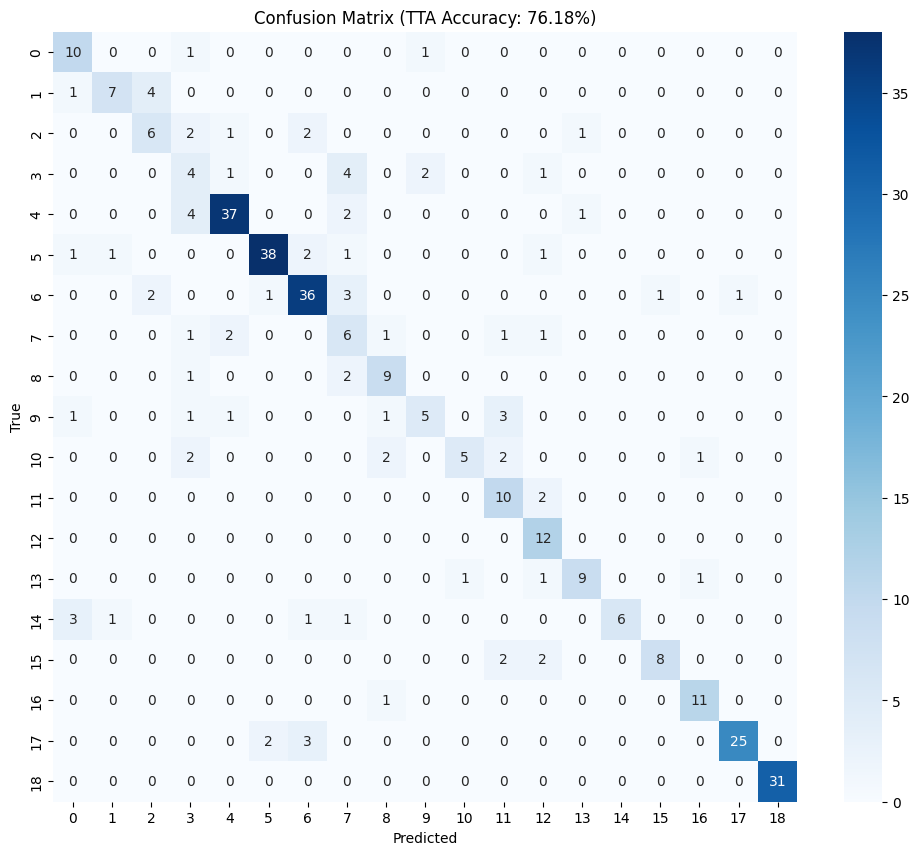

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ====================================================
# 1. 설정 및 장치 확인
# ====================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# ====================================================
# 2. 모델 구조 정의 (저장된 모델을 불러오기 위해 필요)
# ====================================================
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        self.branch1 = nn.Sequential(nn.Conv1d(in_channels, out_channels, 15, padding=7), nn.BatchNorm1d(out_channels), nn.ReLU())
        self.branch2 = nn.Sequential(nn.Conv1d(in_channels, out_channels, 51, padding=25), nn.BatchNorm1d(out_channels), nn.ReLU())
        self.branch3 = nn.Sequential(nn.Conv1d(in_channels, out_channels, 101, padding=50), nn.BatchNorm1d(out_channels), nn.ReLU())
        self.branch4 = nn.Sequential(nn.MaxPool1d(3, 1, 1), nn.Conv1d(in_channels, out_channels, 1), nn.BatchNorm1d(out_channels), nn.ReLU())
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)

class TemporalAttention(nn.Module):
    def __init__(self, d_model):
        super(TemporalAttention, self).__init__()
        self.query = nn.Linear(d_model, d_model // 2)
        self.score = nn.Linear(d_model // 2, 1)
    def forward(self, x):
        x_perm = x.permute(0, 2, 1) 
        attn = torch.tanh(self.query(x_perm))
        scores = self.score(attn)
        weights = torch.softmax(scores, dim=1) 
        context = x_perm * weights
        context = torch.sum(context, dim=1)
        return context

class MultiScale_EMG_Model(nn.Module):
    def __init__(self, num_classes, input_channels, window_size, d_model=128): 
        super(MultiScale_EMG_Model, self).__init__()
        self.stem = nn.Sequential(nn.Conv1d(input_channels, 64, 7, stride=4, padding=3), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2))
        self.inception1 = InceptionBlock(64, 32)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.2)
        self.inception2 = InceptionBlock(128, 64)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.conv_reduce = nn.Conv1d(256, d_model, 1)
        self.bn_reduce = nn.BatchNorm1d(d_model)
        self.relu = nn.ReLU()
        self.temp_attn = TemporalAttention(d_model)
        self.classifier = nn.Sequential(nn.Linear(d_model, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, num_classes))
    def forward(self, x):
        x = self.stem(x)
        x = self.inception1(x); x = self.pool1(x); x = self.dropout1(x)
        x = self.inception2(x); x = self.pool2(x); x = self.dropout2(x)
        x = self.conv_reduce(x); x = self.bn_reduce(x); x = self.relu(x)
        x = self.temp_attn(x); x = self.classifier(x)
        return x

class EMGDataset(Dataset):
    def __init__(self, X, y):
        # 평가시에는 Transpose가 이미 되어있다고 가정하거나 확인 필요
        # 여기서는 DataLoader에 넣기 전 미리 처리된 X를 받음
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ====================================================
# 3. 데이터 로드 및 전처리 (변수 복원 과정)
# ====================================================
def load_data_and_prepare_loader():
    base_path = r'C:\PJ_python\Project-Gesture-classification-technique-based-on-multiple-EMG-datasets-main\processed_data'
    
    print("📂 데이터 정보를 다시 읽어옵니다...")
    try:
        # 데이터 로드
        X = np.load(os.path.join(base_path, 'X_combined.npy')).astype(np.float32)
        y = np.load(os.path.join(base_path, 'y_combined.npy'))
    except FileNotFoundError:
        print("❌ 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        return None, None, None, None

    # 차원 정보 복원
    n, dim1, dim2 = X.shape
    if dim1 < dim2: 
        channels, window_size = dim1, dim2
    else: 
        channels, window_size = dim2, dim1
        X = np.transpose(X, (0, 2, 1))

    print(f"📌 감지된 설정 - Channels: {channels}, Window: {window_size}")

    # 스케일링 (학습 때와 동일하게 적용해야 함)
    print("⚖️ Scaling 적용 중...")
    X_perm = np.transpose(X, (0, 2, 1)).reshape(-1, channels)
    scaler = StandardScaler(copy=False)
    X_perm = scaler.fit_transform(X_perm)
    X = np.transpose(X_perm.reshape(n, window_size, channels), (0, 2, 1))
    
    # 라벨링
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    num_classes = len(np.unique(y_enc))
    print(f"📌 클래스 개수: {num_classes}")

    # Validation Set 분리 (학습 때와 동일한 seed=42 사용 필수)
    _, X_val, _, y_val = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
    
    # DataLoader 생성
    val_dataset = EMGDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return val_loader, num_classes, channels, window_size

# ====================================================
# 4. TTA 평가 실행
# ====================================================
def evaluate_with_tta(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    print("\n🚀 TTA(Test Time Augmentation) 평가 시작...")
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 1. 원본
            output1 = model(inputs)
            # 2. 확대 (5%)
            output2 = model(inputs * 1.05)
            # 3. 축소 (5%)
            output3 = model(inputs * 0.95)
            
            # Soft Voting
            final_output = (output1 + output2 + output3) / 3.0
            _, preds = torch.max(final_output, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    acc = accuracy_score(all_labels, all_preds)
    print(f"✨ TTA 적용 최종 정확도: {acc*100:.2f}%")
    return all_labels, all_preds

# --- 메인 실행 흐름 ---
if __name__ == "__main__":
    # 1. 데이터 및 변수 준비
    val_loader, num_classes, channels, window_size = load_data_and_prepare_loader()
    
    if val_loader is not None:
        # 2. 모델 초기화
        model = MultiScale_EMG_Model(num_classes, channels, window_size, d_model=128).to(device)
        
        # 3. 가중치 로드 (경로 확인 필수)
        # best_emg_inception.pth 파일이 현재 폴더에 있어야 합니다.
        model_path = 'best_emg_onecycle.pth' 
        
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path))
            print("✅ Best Model 로드 완료.")
            
            # 4. 평가 및 시각화
            y_true, y_pred = evaluate_with_tta(model, val_loader, device)
            
            # Confusion Matrix
            plt.figure(figsize=(12, 10))
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix (TTA Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%)')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
        else:
            print(f"⚠️ 모델 파일({model_path})을 찾을 수 없습니다. 경로를 확인해주세요.")